<a href="https://colab.research.google.com/github/gauthiermartin/pytorch-deep-learning-course/blob/main/04_pytorch_custom_datasets_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Datasets Exercises Template

Welcome to the 04. PyTorch Custom Datasets exercise template.

The best way to practice PyTorch code is to write more PyTorch code.

So read the original notebook and try to complete the exercises by writing code where it's required.

Feel free to reference the original resources whenever you need but should practice writing all of the code yourself.

## Resources

1. These exercises/solutions are based on [notebook 04 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/04_pytorch_custom_datasets/).
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/vsFMF9wqWx0).
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [2]:
# Check for GPU
!nvidia-smi

Thu Sep 14 11:01:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Import torch
import torch
from torch import nn

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

2.0.1+cu118


'cuda'

## 1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

1. Add more layers / units to our model
2. Tweak the learning rate
3. Train for longer

## 2. Recreate the data loading functions we built in [sections 1, 2, 3 and 4 of notebook 04](https://www.learnpytorch.io/04_pytorch_custom_datasets/). You should have train and test `DataLoader`'s ready to use.

In [4]:
# 1. Get data
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_exercise"
zip_file = data_path / "pizza_steak_and_sushi_exercise.zip"

if image_path.is_dir():
  print(f"{image_path} directory already existing... Skipping download")
else:
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

  with open(zip_file , "wb") as f:
    response = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak and shushi data")
    f.write(response.content)

  with zipfile.ZipFile(zip_file, "r") as zip_file:
    print("Unzipping pizza, steak and sushi data")
    zip_file.extractall(image_path)

data/pizza_steak_sushi_exercise does not exist, creating one...
Unzipping pizza, steak and sushi data


In [5]:
 # 2. Become one with the data
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi_exercise'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_exercise/train'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi_exercise/train/pizza'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi_exercise/train/sushi'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi_exercise/train/steak'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_exercise/test'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi_exercise/test/pizza'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi_exercise/test/sushi'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi_exercise/test/steak'.


In [6]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi_exercise/train'),
 PosixPath('data/pizza_steak_sushi_exercise/test'))

Random image path: data/pizza_steak_sushi_exercise/train/pizza/3338774.jpg
Random image class: 3338774
Image height: 289
Image width: 512


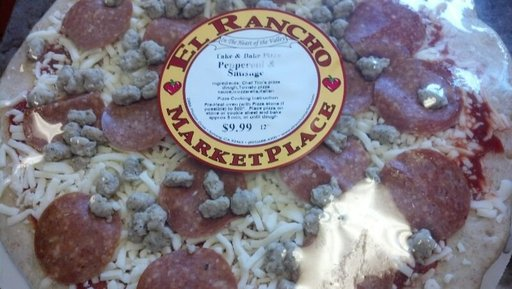

In [7]:
# Visualize an image
import random
from PIL import Image

RANDOM_SEED = 42
BATCH_SIZE = 32

# Set seed
random.seed(RANDOM_SEED)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get a random image from the list
random_image_path = random.choice(image_path_list)

# 3. Get the image class
random_image_class = random_image_path.stem

# 4. Open the image
image = Image.open(random_image_path)

# 5. Display the image and metadata
print(f"Random image path: {random_image_path}")
print(f"Random image class: {random_image_class}")
print(f"Image height: {image.height}")
print(f"Image width: {image.width}")
image


(-0.5, 511.5, 288.5, -0.5)

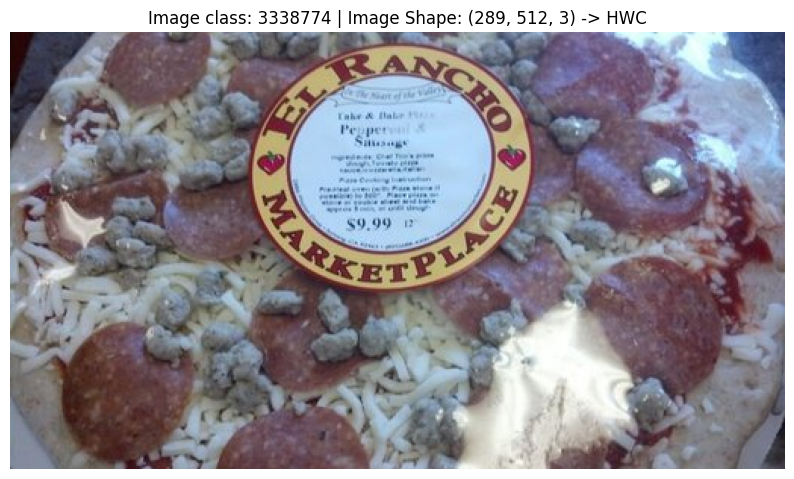

In [8]:
# Do the image visualization with matplotlib
import numpy as np
import matplotlib.pyplot as plt

random_image_array = np.asarray(image)

plt.figure(figsize=(10,7))
plt.imshow(random_image_array)
plt.title(f"Image class: {random_image_class} | Image Shape: {random_image_array.shape} -> HWC")
plt.axis(False)

We've got some images in our folders.

Now we need to make them compatible with PyTorch by:
1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

# 3.1 Transforming data with torchvision.transforms

In [9]:
# Write transform for turning images into tensors
from torchvision import transforms

data_transforms = transforms.Compose([
        transforms.Resize(size=(64, 64)),
        transforms.ToTensor()
])


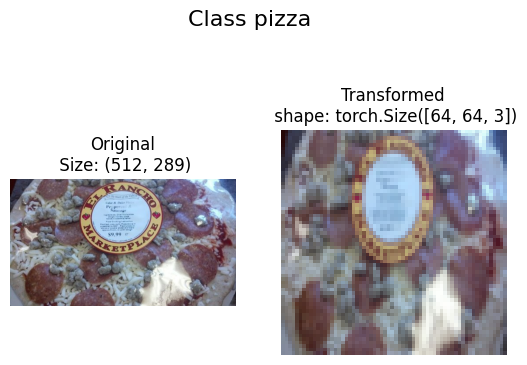

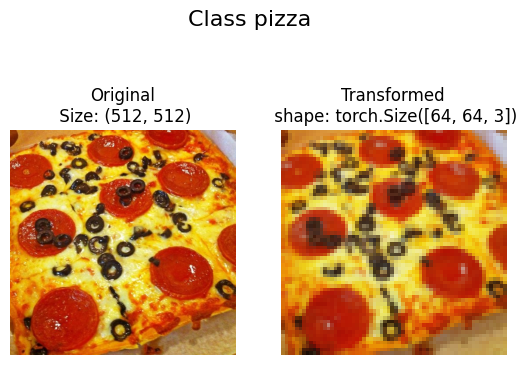

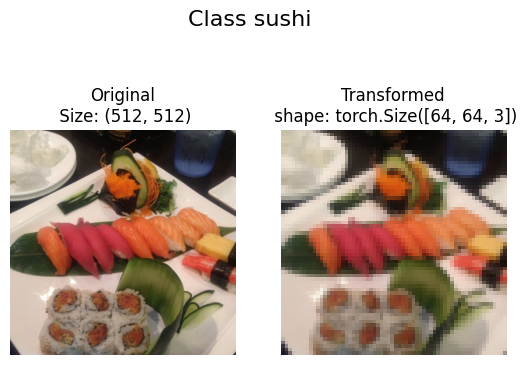

In [10]:
# Write a function to plot transformed images
def plot_transformed_images(image_paths, transforms, n=3, seed=None):
  if seed:
    random.seed(seed)

  # Get n random image paths
  random_image_paths = random.sample(image_paths, k=n)

  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\n Size: {f.size}")
      ax[0].axis(False)

      # Transform image and plot
      transformed_image = transforms(f).permute(1, 2, 0) # C, H, W => H, W, C
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\n shape: {transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class {image_path.parent.stem}", fontsize=16)

plot_transformed_images(
    image_paths=image_path_list,
    transforms=data_transforms,
    n=3,
    seed=RANDOM_SEED
)


### Load image data using `ImageFolder`

In [11]:
# Use ImageFolder to create dataset(s)
from torchvision.datasets import ImageFolder
train_data = ImageFolder(root=train_dir, transform=data_transforms)
test_data = ImageFolder(root=test_dir, transform=data_transforms)
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi_exercise/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi_exercise/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ))

In [12]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [13]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [14]:
# Check the lengths of each dataset
len(train_data), len(test_data)

(225, 75)

In [15]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
import os
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    num_workers=os.cpu_count(),
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=32,
    num_workers=os.cpu_count(),
    shuffle=False
)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7ade6508f070>,
 <torch.utils.data.dataloader.DataLoader at 0x7add85754ac0>)

In [16]:
# How many batches of images are in our data loaders?
len(train_dataloader), len(test_dataloader)

(8, 3)

## 3. Recreate `model_0` we built in section 7 of notebook 04.

In [17]:
class TinyVGG(nn.Module):

  def __init__(self, input_shape:int, hidden_units: int, output_shape: int) -> None:
    super().__init__()

    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(
            in_channels=input_shape,
            out_channels=hidden_units,
            kernel_size=3,
            padding=0,
            stride=1
        ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=3,
            padding=0,
            stride=1
        ),
        nn.ReLU(),
        nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=3,
            padding=0,
            stride=1
        ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=3,
            padding=0,
            stride=1
        ),
        nn.ReLU(),
        nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(
            in_features=hidden_units * 13 * 13,
            out_features=output_shape
        )
    )

  def forward(self, x):
    return (self.classifier(self.conv_block_2(self.conv_block_1(x))))

In [18]:
torch.manual_seed(RANDOM_SEED)
model_0 = TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(train_data.classes)
).to(device)

## 4. Create training and testing functions for `model_0`.

In [19]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):

  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader and data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    train_pred_logits = model(X)
    # 2. Calculate and accumulate loss
    loss = loss_fn(train_pred_logits, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate and accumualte accuracy metric across all batches
    y_pred_class = torch.argmax(torch.softmax(train_pred_logits, dim=1), dim=1)
    #print(f"A:{y_pred_class=}")
    #print(f"B:{y_pred_class == y}")
    #print(f"C:{type((y_pred_class == y).sum())}")
    #print(f"D:{type((y_pred_class == y).sum().item())}")
    train_acc +=(y_pred_class == y).sum().item()/len(train_pred_logits)

  # Adjust metrics to get average loss and average accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)

  return train_loss, train_acc


In [20]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):

  # Put model in eval mode
  model.eval()

  # Setup the test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):

      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)
      # 2. Calculuate and accumulate loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate and accumulate accuracy
      test_pred_labels = torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1)
      test_acc += (test_pred_labels==y).sum().item()/len(test_pred_labels)

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)

  return test_loss, test_acc


In [21]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    # Test step
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)

    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the results dictionary
  return results


## 5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer.

In [22]:
from timeit import default_timer as timer

# Train for 5 epochs
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

model_0 = TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(train_data.classes)
).to(device)


loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    params=model_0.parameters(),
    lr=0.001
)

start_time = timer()
model_0_results_1 = train(
    model=model_0,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn
)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1063 | train_acc: 0.3047 | test_loss: 1.0983 | test_acc: 0.3011
Epoch: 2 | train_loss: 1.0998 | train_acc: 0.3281 | test_loss: 1.0697 | test_acc: 0.5417
Epoch: 3 | train_loss: 1.0869 | train_acc: 0.4883 | test_loss: 1.0808 | test_acc: 0.4924
Epoch: 4 | train_loss: 1.0845 | train_acc: 0.4023 | test_loss: 1.0607 | test_acc: 0.5833
Epoch: 5 | train_loss: 1.0663 | train_acc: 0.4219 | test_loss: 1.0657 | test_acc: 0.5644
Total training time: 22.617 seconds


In [28]:
# Train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_1 = TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(train_data.classes)
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    params=model_1.parameters(),
    lr=0.001
)

start_time = timer()

model_1_results = train(
    model=model_1,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=20
)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1063 | train_acc: 0.3047 | test_loss: 1.0983 | test_acc: 0.3011
Epoch: 2 | train_loss: 1.0998 | train_acc: 0.3281 | test_loss: 1.0697 | test_acc: 0.5417
Epoch: 3 | train_loss: 1.0869 | train_acc: 0.4883 | test_loss: 1.0807 | test_acc: 0.4924
Epoch: 4 | train_loss: 1.0844 | train_acc: 0.4023 | test_loss: 1.0606 | test_acc: 0.5833
Epoch: 5 | train_loss: 1.0662 | train_acc: 0.4141 | test_loss: 1.0657 | test_acc: 0.5644
Epoch: 6 | train_loss: 1.0309 | train_acc: 0.4375 | test_loss: 1.0149 | test_acc: 0.5426
Epoch: 7 | train_loss: 0.9872 | train_acc: 0.4219 | test_loss: 0.9379 | test_acc: 0.6042
Epoch: 8 | train_loss: 0.9583 | train_acc: 0.5469 | test_loss: 1.0228 | test_acc: 0.4328
Epoch: 9 | train_loss: 0.9275 | train_acc: 0.5820 | test_loss: 1.1072 | test_acc: 0.3324
Epoch: 10 | train_loss: 0.9725 | train_acc: 0.4609 | test_loss: 0.9916 | test_acc: 0.4129
Epoch: 11 | train_loss: 0.8676 | train_acc: 0.5156 | test_loss: 0.9518 | test_acc: 0.5729
Epoch: 12 | train_l

In [29]:
# Train for 50 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_2 = TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(train_data.classes)
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    params=model_2.parameters(),
    lr=0.001
)

start_time = timer()

model_2_results = train(
    model=model_2,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=50
)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1063 | train_acc: 0.3047 | test_loss: 1.0983 | test_acc: 0.3011
Epoch: 2 | train_loss: 1.0998 | train_acc: 0.3281 | test_loss: 1.0697 | test_acc: 0.5417
Epoch: 3 | train_loss: 1.0869 | train_acc: 0.4883 | test_loss: 1.0808 | test_acc: 0.4924
Epoch: 4 | train_loss: 1.0845 | train_acc: 0.4023 | test_loss: 1.0606 | test_acc: 0.5833
Epoch: 5 | train_loss: 1.0664 | train_acc: 0.4180 | test_loss: 1.0658 | test_acc: 0.5644
Epoch: 6 | train_loss: 1.0311 | train_acc: 0.4414 | test_loss: 1.0148 | test_acc: 0.5426
Epoch: 7 | train_loss: 0.9867 | train_acc: 0.4219 | test_loss: 0.9330 | test_acc: 0.5938
Epoch: 8 | train_loss: 0.9667 | train_acc: 0.5781 | test_loss: 0.9983 | test_acc: 0.4328
Epoch: 9 | train_loss: 0.9221 | train_acc: 0.5938 | test_loss: 1.0686 | test_acc: 0.3324
Epoch: 10 | train_loss: 0.9863 | train_acc: 0.4648 | test_loss: 1.0365 | test_acc: 0.3939
Epoch: 11 | train_loss: 0.8672 | train_acc: 0.5273 | test_loss: 0.9603 | test_acc: 0.6042
Epoch: 12 | train_l

It looks like our model is starting to overfit towards the end (performing far better on the training data than on the testing data).

In order to fix this, we'd have to introduce ways of preventing overfitting.

## 6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [30]:
# Double the number of hidden units and train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_3 = TinyVGG(
    input_shape=3,
    hidden_units=20,
    output_shape=len(train_data.classes)
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    params=model_3.parameters(),
    lr=0.001
)

start_time = timer()

model_3_results = train(
    model=model_3,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=20
)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1031 | train_acc: 0.2852 | test_loss: 1.1014 | test_acc: 0.1979
Epoch: 2 | train_loss: 1.1017 | train_acc: 0.2930 | test_loss: 1.1019 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.0994 | train_acc: 0.2539 | test_loss: 1.0900 | test_acc: 0.4631
Epoch: 4 | train_loss: 1.1117 | train_acc: 0.3008 | test_loss: 1.0931 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0948 | train_acc: 0.4375 | test_loss: 1.1006 | test_acc: 0.2812
Epoch: 6 | train_loss: 1.0918 | train_acc: 0.5508 | test_loss: 1.1009 | test_acc: 0.2708
Epoch: 7 | train_loss: 1.0637 | train_acc: 0.5156 | test_loss: 1.0957 | test_acc: 0.2708
Epoch: 8 | train_loss: 1.0433 | train_acc: 0.4609 | test_loss: 1.1342 | test_acc: 0.2500
Epoch: 9 | train_loss: 0.9990 | train_acc: 0.4922 | test_loss: 1.1783 | test_acc: 0.2812
Epoch: 10 | train_loss: 1.1518 | train_acc: 0.3750 | test_loss: 1.0710 | test_acc: 0.3523
Epoch: 11 | train_loss: 1.0251 | train_acc: 0.5391 | test_loss: 1.0722 | test_acc: 0.4015
Epoch: 12 | train_l

It looks like the model is still overfitting, even when changing the number of hidden units.

To fix this, we'd have to look at ways to prevent overfitting with our model.

## 7. Double the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?
* **Note:** You can use the [custom data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) to scale up your Food101 dataset.
* You can also find the [already formatted double data (20% instead of 10% subset) dataset on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip), you will need to write download code like in exercise 2 to get it into this notebook.

In [31]:
# Download 20% data for Pizza/Steak/Sushi from GitHub
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi 20% data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...")
    zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza, steak, sushi 20% data...


In [32]:
# See how many images we have
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi_20_percent'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/train'.
There are 0 directories and 154 images in 'data/pizza_steak_sushi_20_percent/train/pizza'.
There are 0 directories and 150 images in 'data/pizza_steak_sushi_20_percent/train/sushi'.
There are 0 directories and 146 images in 'data/pizza_steak_sushi_20_percent/train/steak'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/test'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/pizza'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/sushi'.
There are 0 directories and 58 images in 'data/pizza_steak_sushi_20_percent/test/steak'.


Excellent, we now have double the training and testing images...

In [33]:
# Create the train and test paths
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [35]:
# Turn the 20 percent datapaths into Datasets and DataLoaders
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

simple_transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.ToTensor()
])

# Create datasets
train_data_20_percent = ImageFolder(
    root=train_data_20_percent_path,
    transform=simple_transform
  )

test_data_20_percent = ImageFolder(
    root=test_data_20_percent_path,
    transform=simple_transform
)

# Create dataloaders
train_dataloader_20_percent = DataLoader(
    dataset=train_data_20_percent,
    batch_size=BATCH_SIZE,
    num_workers=os.cpu_count(),
    shuffle=True
)

test_dataloader_20_percent = DataLoader(
    dataset=test_data_20_percent,
    num_workers=os.cpu_count(),
    shuffle=False
)


In [36]:
# Train a model with increased amount of data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_5 = TinyVGG(
    input_shape=3,
    hidden_units=20,
    output_shape=len(train_data.classes)
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    params=model_3.parameters(),
    lr=0.001
)

start_time = timer()

model_5_results = train(
    model=model_5,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=20
)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0958 | train_acc: 0.4141 | test_loss: 1.1045 | test_acc: 0.1979
Epoch: 2 | train_loss: 1.1008 | train_acc: 0.2930 | test_loss: 1.1045 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.1009 | train_acc: 0.2930 | test_loss: 1.1045 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.0954 | train_acc: 0.4141 | test_loss: 1.1045 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.0954 | train_acc: 0.4141 | test_loss: 1.1045 | test_acc: 0.1979
Epoch: 6 | train_loss: 1.0956 | train_acc: 0.4141 | test_loss: 1.1045 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.1012 | train_acc: 0.2930 | test_loss: 1.1045 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.0956 | train_acc: 0.4141 | test_loss: 1.1045 | test_acc: 0.1979
Epoch: 9 | train_loss: 1.1014 | train_acc: 0.2930 | test_loss: 1.1045 | test_acc: 0.1979
Epoch: 10 | train_loss: 1.1001 | train_acc: 0.2930 | test_loss: 1.1045 | test_acc: 0.1979
Epoch: 11 | train_loss: 1.1006 | train_acc: 0.2930 | test_loss: 1.1045 | test_acc: 0.1979
Epoch: 12 | train_l

## 8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction.
* Does the model you trained in exercise 7 get it right?
* If not, what do you think you could do to improve it?

In [49]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download image if it does not exist
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    response = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/data/04-pizza-dad.jpeg")
    print(f"Downloading {custom_image_path}....")
    f.write(response.content)
else:
  print(f"{custom_image_path} already exist.Skipping download")

data/04-pizza-dad.jpeg already exist.Skipping download


In [47]:
from typing import List

def pred_and_plot_image(
    model: torch.nn.Module,
    image_path: str,
    class_names: List[str] = None,
    transform=None,
    device=device
):
  """Make a predicition on a target image with a trained model and plots the image predicition."""

  # Load in the image
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

  # Divide the image pixel value by 255 to get them between [0,1]
  target_image = target_image / 255.

  # Transform our data if necessary
  if transform:
    target_image = transform(target_image)

  # Make sure the model is on the target device
  model.to(device)

  # Add and extra dimension to the image (batch dimenssion)
  target_image = target_image.unsqueeze(0)

  # Turn on eval / inference mode
  model.eval()
  with torch.inference_mode():
    # Make a prediction
    target_image_pred = model(target_image.to(device))


  # Convert logits to pred probs
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

  # Convert preds probs to labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  # Plot the image alongside the predicition and predicition prob
  plt.imshow(target_image.squeeze().permute(1, 2, 0)) # remove batch dim and rearrange shape to
  if class_names:
    title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.cpu():.3f}"
  else:
    title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.cpu():.3f}"
  plt.title(title)
  plt.axis(False)

In [ ]:
pred_and_plot_image(
    model=model_5,
    image_path=custom_image_path,
    class_names=class_names,
    transform=simple_transform,
    device=device
)